In [20]:
import numpy as np
import pandas as pd
from scipy.stats import laplace, norm
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Logistic Ridge Regression Functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss(beta, X, y, lambda_):
    logits = X @ beta
    log_likelihood = -np.mean(y * logits - np.log(1 + np.exp(logits))) * X.shape[0]
    ridge_penalty = 0.5 * lambda_ * np.sum(beta**2)
    return log_likelihood + ridge_penalty

def gradient(beta, X, y, lambda_):
    prob = sigmoid(X @ beta)
    return -X.T @ (y - prob) + lambda_ * beta

def hessian(beta, X, lambda_):
    prob = sigmoid(X @ beta)
    w = prob * (1 - prob)  # shape (n,)
    WX = X * w[:, np.newaxis]  # same effect as diag
    return X.T @ WX + lambda_ * np.eye(X.shape[1])

def newton_step(beta_init, X, y, lambda_, tol=1e-6, max_iter=100):
    beta = beta_init.copy()
    for step_count in range(1, max_iter + 1):
        grad = gradient(beta, X, y, lambda_)
        hess = hessian(beta, X, lambda_)
        step = np.linalg.solve(hess, grad)
        beta -= step
        if np.linalg.norm(step) < tol:
            return beta, step_count
    return beta, max_iter


# Set seed for reproducibility
np.random.seed(1)

# Parameters
n         = 500  # Fixed sample size
p         = 1000  # Fixed number of features
lambda_   = 0.01  # Regularization constant
beta_star = np.random.normal(0, 1, p)
X         = np.random.normal(0, 1 / np.sqrt(n), (n, p))
logits    = X @ beta_star
prob      = sigmoid(logits)
y         = np.random.binomial(1, prob)
beta_init = np.random.normal(0, 1, p) * 0.01
# Compute Newton steps for beta_hat
beta_hat, steps_used = newton_step(beta_init, X, y, lambda_)
# Compute hat matrix H
# Compute predicted probabilities and weights
p_hat = sigmoid(X @ beta_hat)
w = p_hat * (1 - p_hat)  # shape (n,)

# Weighted design matrix
WX = X * w[:, np.newaxis]  # element-wise multiply each row of X by w_i

# Compute Hessian and its inverse
hessian_matrix = X.T @ WX + lambda_ * np.eye(p)
hessian_inv = np.linalg.solve(hessian_matrix, np.eye(p))  # shape (p, p)

# Compute diagonal of the hat matrix: H_ii = w_i * x_i^T @ hessian_inv @ x_i
H_diag = np.einsum('ij,jk,ik->i', X, hessian_inv, X) * w  # shape (n,)

# Trace of H divided by number of features
tr_H = np.sum(H_diag) / p

print(f"Effective df (tr(H)/p) = {tr_H:.4f}, lambda = {lambda_}, n = {n}, p = {p}, Newton Steps: {steps_used}")



Effective df (tr(H)/p) = 0.3450, lambda = 0.01, n = 500, p = 1000, Newton Steps: 8


In [21]:
m = 100  # number of unseen test points

# Sample m new test points
X_new      = np.random.normal(0, 1 / np.sqrt(n), size=(m, p))
logits_new = X_new @ beta_star
probs_new  = sigmoid(logits_new)
y_new      = np.random.binomial(1, probs_new)

# Precompute full model predictions for all test points
logits_full = X_new @ beta_hat
loss_full   = -y_new * logits_full + np.log(1 + np.exp(logits_full))  # shape (m,)

# Preallocate arrays (n training points × m test points)
loss_changes        = np.zeros((n, m))
approx_loss_changes = np.zeros((n, m))
influence_values    = np.zeros((n, m))

# Compute full-data gradient and Hessian once
eta = X @ beta_hat
p_hat = sigmoid(eta)
w = p_hat * (1 - p_hat)
WX = X * w[:, np.newaxis]
hessian_matrix = X.T @ WX + lambda_ * np.eye(p)
hessian_matrix_inv = np.linalg.solve(hessian_matrix, np.eye(p))  # shared for all i

# Loop over training points
for i in range(n):
    # Leave-one-out retraining
    X_minus_i = np.delete(X, i, axis=0)
    y_minus_i = np.delete(y, i)

    beta_init_minus_i = np.random.normal(0, 1, p) * 0.01
    beta_hat_minus_i, steps = newton_step(beta_init_minus_i, X_minus_i, y_minus_i, lambda_)

    # True LOO loss on all test points
    logits_minus_i = X_new @ beta_hat_minus_i
    loss_minus_i = -y_new * logits_minus_i + np.log(1 + np.exp(logits_minus_i))  # shape (m,)
    loss_changes[i, :] = loss_minus_i - loss_full

    # First-order approx beta_{/i}
    w_minus_i = np.delete(w, i)
    WX_i = X_minus_i * w_minus_i[:, np.newaxis]
    hessian_i = X_minus_i.T @ WX_i + lambda_ * np.eye(p)
    hessian_i_inv = np.linalg.solve(hessian_i, np.eye(p))

    # First derivative of logistic loss at point i
    p_i = p_hat[i]
    y_i = y[i]
    x_i = X[i]
    grad_i = (p_i - y_i) * x_i

    # First order correction
    beta_tilde_i = beta_hat + hessian_i_inv @ grad_i

    # Loss with approx beta on test points
    logits_tilde_i = X_new @ beta_tilde_i
    loss_tilde_i = -y_new * logits_tilde_i + np.log(1 + np.exp(logits_tilde_i))
    approx_loss_changes[i, :] = loss_tilde_i - loss_full

    # Classical Influence estimates on test loss
    for j in range(m):
        p_new = probs_new[j]
        grad_test = (p_new - y_new[j]) * X_new[j]
        beta_influence_i = beta_hat + hessian_matrix_inv @ grad_i
        logit_influence_i = X_new[j] @ beta_influence_i
        loss_influence_i = -y_new[j] * logit_influence_i + np.log(1 + np.exp(logit_influence_i))
        #influence_values[i, j] = loss_influence_i - loss_full[j] # wrapping the loss around it
        influence_values[i, j] = grad_test @ hessian_matrix_inv @ grad_i

    # Optionally print summary stats per training point
    print(f"Point {i:4d}: ΔLoss = {loss_changes[i,1]:7.4f},  ΔLoss_tilde = {approx_loss_changes[i,1]:7.4f}, Influence = {influence_values[i,1]:9.5f}, Steps = {steps:2d}")


Point    0: ΔLoss = -0.0484,  ΔLoss_tilde = -0.0480, Influence =  -0.01689, Steps =  8
Point    1: ΔLoss = -0.0051,  ΔLoss_tilde = -0.0051, Influence =  -0.00522, Steps =  8
Point    2: ΔLoss =  0.0161,  ΔLoss_tilde =  0.0161, Influence =   0.01697, Steps =  8
Point    3: ΔLoss =  0.0150,  ΔLoss_tilde =  0.0149, Influence =   0.00926, Steps =  8
Point    4: ΔLoss = -0.0020,  ΔLoss_tilde = -0.0020, Influence =  -0.00355, Steps =  8
Point    5: ΔLoss = -0.0344,  ΔLoss_tilde = -0.0344, Influence =  -0.02599, Steps =  8
Point    6: ΔLoss =  0.0023,  ΔLoss_tilde =  0.0023, Influence =   0.00324, Steps =  8
Point    7: ΔLoss = -0.2047,  ΔLoss_tilde = -0.2060, Influence =  -0.06167, Steps =  8
Point    8: ΔLoss = -0.0957,  ΔLoss_tilde = -0.0957, Influence =  -0.04472, Steps =  8
Point    9: ΔLoss =  0.0156,  ΔLoss_tilde =  0.0157, Influence =   0.01160, Steps =  8
Point   10: ΔLoss =  0.0414,  ΔLoss_tilde =  0.0413, Influence =   0.02692, Steps =  8
Point   11: ΔLoss = -0.1007,  ΔLoss_tilde =

Kendall's Tau (approx):
  Mean = 0.9957
  Std  = 0.0007

Kendall's Tau (influence):
  Mean = 0.8834
  Std  = 0.0051



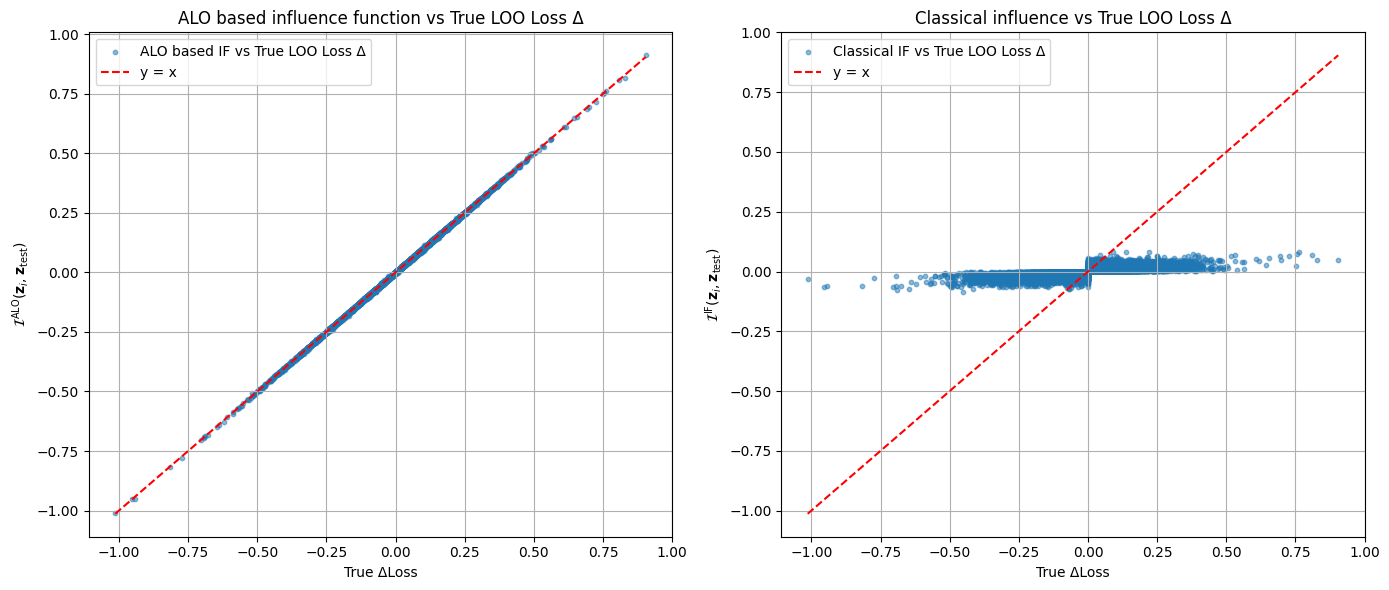


Five-number summary of Kendall's tau (Tilde):
   Min: 0.9931
    Q1: 0.9954
Median: 0.9958
    Q3: 0.9961
   Max: 0.9970

Five-number summary of Kendall's tau (Influence):
   Min: 0.8699
    Q1: 0.8801
Median: 0.8840
    Q3: 0.8876
   Max: 0.8946


In [23]:
import numpy as np
from scipy.stats import kendalltau, spearmanr
import matplotlib.pyplot as plt
#plt.rcParams['text.usetex'] = False  # Set to True if using full LaTeX setup


# Prepare storage
kendall_tilde_values = []
kendall_infl_values = []
spearman_tilde_values = []
spearman_infl_values = []

n_train, m_test = loss_changes.shape

# Loop over each test point (column-wise)
for j in range(m_test):
    a = loss_changes[:, j]
    a_tilde = approx_loss_changes[:, j]
    a_infl = influence_values[:, j]

    # Compute correlations
    tau_tilde, _ = kendalltau(a, a_tilde)
    tau_infl, _ = kendalltau(a, a_infl)
    rho_tilde, _ = spearmanr(a, a_tilde)
    rho_infl, _ = spearmanr(a, a_infl)

    # Store them
    kendall_tilde_values.append(tau_tilde)
    kendall_infl_values.append(tau_infl)
    spearman_tilde_values.append(rho_tilde)
    spearman_infl_values.append(rho_infl)

# Convert lists to arrays
kendall_tilde_values = np.array(kendall_tilde_values)
kendall_infl_values = np.array(kendall_infl_values)
spearman_tilde_values = np.array(spearman_tilde_values)
spearman_infl_values = np.array(spearman_infl_values)



# Mean and standard deviation for Kendall's Tau

def print_mean_std(name, data):
    mean = np.mean(data)
    std = np.std(data)
    print(f"{name}:")
    print(f"  Mean = {mean:.4f}")
    print(f"  Std  = {std:.4f}\n")

print_mean_std("Kendall's Tau (approx)", kendall_tilde_values)
print_mean_std("Kendall's Tau (influence)", kendall_infl_values)


# === Add Scatter Plots ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Flatten everything
exact = loss_changes.flatten()
tilde = approx_loss_changes.flatten()
influence = influence_values.flatten()
line = np.linspace(np.min(exact), np.max(exact), 100)

# Scatter: Approx vs True
axes[0].scatter(exact, tilde, s=10, alpha=0.5, label="ALO based IF vs True LOO Loss Δ")
axes[0].plot(line, line, color='red', linestyle='--', label='y = x')
axes[0].grid(True)
axes[0].set_title("ALO based influence function vs True LOO Loss Δ")
axes[0].set_xlabel("True ΔLoss")
axes[0].set_ylabel(r"$\mathcal{I}^{\text{ALO}}(\mathbf{z}_i, \mathbf{z}_{\text{test}})$")
axes[0].legend()

# Scatter: Influence vs True
axes[1].scatter(exact, influence, s=10, alpha=0.5, label="Classical IF vs True LOO Loss Δ")
axes[1].plot(line, line, color='red', linestyle='--', label='y = x')
axes[1].grid(True)
axes[1].set_title("Classical influence vs True LOO Loss Δ")
axes[1].set_xlabel("True ΔLoss")
axes[1].set_ylabel(r"$\mathcal{I}^{\text{IF}}(\mathbf{z}_i, \mathbf{z}_{\text{test}})$")
axes[1].legend()


plt.tight_layout()
plt.show()

# Convert to arrays (if not already)
kendall_tilde = np.array(kendall_tilde_values)
kendall_infl = np.array(kendall_infl_values)

# Define function for five-number summary
def five_number_summary(x):
    return {
        "Min": np.min(x),
        "Q1": np.percentile(x, 25),
        "Median": np.median(x),
        "Q3": np.percentile(x, 75),
        "Max": np.max(x)
    }

# Compute summaries
summary_tilde = five_number_summary(kendall_tilde)
summary_infl = five_number_summary(kendall_infl)

# Print results
print("\nFive-number summary of Kendall's tau (Tilde):")
for k, v in summary_tilde.items():
    print(f"{k:>6}: {v:.4f}")

print("\nFive-number summary of Kendall's tau (Influence):")
for k, v in summary_infl.items():
    print(f"{k:>6}: {v:.4f}")


In [17]:
import numpy as np
import pandas as pd
from scipy.stats import kendalltau

# Core logistic regression utilities
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def gradient(beta, X, y, lambda_):
    p = sigmoid(X @ beta)
    return -X.T @ (y - p) + lambda_ * beta

def hessian(beta, X, lambda_):
    p = sigmoid(X @ beta)
    w = p * (1 - p)
    WX = X * w[:, np.newaxis]
    return X.T @ WX + lambda_ * np.eye(X.shape[1])

def newton_step(beta_init, X, y, lambda_, tol=1e-6, max_iter=100):
    beta = beta_init.copy()
    for _ in range(max_iter):
        grad = gradient(beta, X, y, lambda_)
        hess = hessian(beta, X, lambda_)
        step = np.linalg.solve(hess, grad)
        beta -= step
        if np.linalg.norm(step) < tol:
            break
    return beta

# Experimental setup
lambda_ = 10
m = 100  # number of test points
n_p_ratio = 0.5
p_list = [500, 1000, 2000]  # change p, n changes accordingly

results = []

for p in p_list:
    n = int(n_p_ratio * p)
    np.random.seed(1)

    # Data generation
    beta_star = np.random.normal(0, 1, p)
    X = np.random.normal(0, 1 / np.sqrt(n), size=(n, p))
    logits = X @ beta_star
    prob = sigmoid(logits)
    y = np.random.binomial(1, prob)
    beta_init = np.random.normal(0, 1, p) * 0.01
    beta_hat = newton_step(beta_init, X, y, lambda_)

    # Test set
    X_new = np.random.normal(0, 1 / np.sqrt(n), size=(m, p))
    logits_new = X_new @ beta_star
    probs_new = sigmoid(logits_new)
    y_new = np.random.binomial(1, probs_new)
    logits_full = X_new @ beta_hat
    loss_full = -y_new * logits_full + np.log(1 + np.exp(logits_full))

    # Preallocate
    loss_changes = np.zeros((n, m))
    approx_loss_changes = np.zeros((n, m))
    influence_values = np.zeros((n, m))

    # Hessian
    eta = X @ beta_hat
    p_hat = sigmoid(eta)
    w = p_hat * (1 - p_hat)
    WX = X * w[:, np.newaxis]
    hessian_matrix = X.T @ WX + lambda_ * np.eye(p)
    hessian_inv = np.linalg.solve(hessian_matrix, np.eye(p))
    H_diag = np.einsum('ij,jk,ik->i', X, hessian_inv, X) * w
    effective_df = np.sum(H_diag) / p

    # Loop over training points
    for i in range(n):
        X_minus_i = np.delete(X, i, axis=0)
        y_minus_i = np.delete(y, i)
        beta_hat_minus_i = newton_step(np.random.normal(0, 1, p) * 0.01, X_minus_i, y_minus_i, lambda_)
        logits_minus_i = X_new @ beta_hat_minus_i
        loss_minus_i = -y_new * logits_minus_i + np.log(1 + np.exp(logits_minus_i))
        loss_changes[i, :] = loss_minus_i - loss_full

        # Approx beta_{-i}
        p_i = p_hat[i]
        y_i = y[i]
        x_i = X[i]
        grad_i = (p_i - y_i) * x_i
        w_minus_i = np.delete(w, i)
        WX_i = X_minus_i * w_minus_i[:, np.newaxis]
        hessian_i = X_minus_i.T @ WX_i + lambda_ * np.eye(p)
        hessian_i_inv = np.linalg.solve(hessian_i, np.eye(p))
        beta_tilde_i = beta_hat + hessian_i_inv @ grad_i
        logits_tilde_i = X_new @ beta_tilde_i
        loss_tilde_i = -y_new * logits_tilde_i + np.log(1 + np.exp(logits_tilde_i))
        approx_loss_changes[i, :] = loss_tilde_i - loss_full

        for j in range(m):
            p_new = probs_new[j]
            grad_test = (p_new - y_new[j]) * X_new[j]
            influence_values[i, j] = grad_test @ hessian_inv @ grad_i

    # Compute Kendall’s Tau per test point
    kendall_approx = []
    kendall_infl = []
    for j in range(m):
        tau1, _ = kendalltau(loss_changes[:, j], approx_loss_changes[:, j])
        tau2, _ = kendalltau(loss_changes[:, j], influence_values[:, j])
        kendall_approx.append(tau1)
        kendall_infl.append(tau2)

    # Compute and store results
    result_entry = {
    "n": n,
    "p": p,
    "n/p": n / p,
    "lambda": lambda_,
    "effective_df": effective_df,
    "kendall_approx_mean": np.nanmean(kendall_approx),
    "kendall_approx_std": np.nanstd(kendall_approx),
    "kendall_infl_mean": np.nanmean(kendall_infl),
    "kendall_infl_std": np.nanstd(kendall_infl),
    }

    # Append to results list
    results.append(result_entry)

    # === Print progress ===
    print(f"Finished: n={n}, p={p}")
    print(f"  eff_df = {effective_df:.4f}")
    print(f"  Kendall approx: mean={result_entry['kendall_approx_mean']:.4f}, std={result_entry['kendall_approx_std']:.4f}")
    print(f"  Kendall infl  : mean={result_entry['kendall_infl_mean']:.4f}, std={result_entry['kendall_infl_std']:.4f}")
    print("-" * 60)


# Save and show results
results_df = pd.DataFrame(results)
print("\n=== Summary Results ===")
print(results_df)


Finished: n=250, p=500
  eff_df = 0.0231
  Kendall approx: mean=1.0000, std=0.0000
  Kendall infl  : mean=0.9989, std=0.0003
------------------------------------------------------------
Finished: n=500, p=1000
  eff_df = 0.0232
  Kendall approx: mean=1.0000, std=0.0000
  Kendall infl  : mean=0.9992, std=0.0001
------------------------------------------------------------
Finished: n=1000, p=2000
  eff_df = 0.0232
  Kendall approx: mean=1.0000, std=0.0000
  Kendall infl  : mean=0.9995, std=0.0000
------------------------------------------------------------

=== Summary Results ===
      n     p  n/p  lambda  effective_df  kendall_approx_mean  \
0   250   500  0.5      10      0.023141             0.999995   
1   500  1000  0.5      10      0.023165             0.999998   
2  1000  2000  0.5      10      0.023170             0.999998   

   kendall_approx_std  kendall_infl_mean  kendall_infl_std  
0            0.000017           0.998924          0.000259  
1            0.000006          

In [18]:
# Use values from the first row for shared lambda and df/p
lambda_val = results_df['lambda'].iloc[0]
df_per_p = results_df['effective_df'].iloc[0]

# Start LaTeX table
latex_table = r"""
\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
\toprule
$n$ & $p$ & $\tau$ (ALO) & $\tau$ (influence) \\
\midrule
"""

# Add table rows
for _, row in results_df.iterrows():
    n = int(row['n'])
    p = int(row['p'])
    tau_alo = f"{row['kendall_approx_mean']:.2f} ({row['kendall_approx_std']:.2f})"
    tau_infl = f"{row['kendall_infl_mean']:.2f} ({row['kendall_infl_std']:.2f})"
    latex_table += f"{n} & {p} & {tau_alo} & {tau_infl} \\\\\n"

# Close the table and add caption with f-string only
latex_table += (
    r"""\bottomrule
\end{tabular}
\caption{Kendall's $\tau$ (mean and std in parentheses) for ALO-based and classical influence-based loss change estimates across different training set sizes computed over a $m=100$ unseen test data points for logistic ridge when """
    + f"$\\lambda={lambda_val:.2f}$, leading to $\\text{{df}}/p={df_per_p:.3f}$."
    + r"""}
\label{tab:kendall_compact}
\end{table}
"""
)

# Print final LaTeX table
print(latex_table)



\begin{table}[ht]
\centering
\begin{tabular}{rrrr}
\toprule
$n$ & $p$ & $\tau$ (ALO) & $\tau$ (influence) \\
\midrule
250 & 500 & 1.00 (0.00) & 1.00 (0.00) \\
500 & 1000 & 1.00 (0.00) & 1.00 (0.00) \\
1000 & 2000 & 1.00 (0.00) & 1.00 (0.00) \\
\bottomrule
\end{tabular}
\caption{Kendall's $\tau$ (mean and std in parentheses) for ALO-based and classical influence-based loss change estimates across different training set sizes computed over a $m=100$ unseen test data points for logistic ridge when $\lambda=10.00$, leading to $\text{df}/p=0.023$.}
\label{tab:kendall_compact}
\end{table}

